In [7]:
import os
import cv2
import shutil
import PIL
import random
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# LOCAL VARIABLES
BASE_DIR = '../../dataset/'
SAVED_MODEL_DIR = BASE_DIR + '../model'

In [9]:
#DATASET_DIR = BASE_DIR + 'final_dataset/'
DATASET_DIR = BASE_DIR + 'Dataset/'
DATA_DIR = Path(DATASET_DIR)
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [10]:
EPOCHS = 5
BATCH_SIZE = 64

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size = BATCH_SIZE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    validation_split = 0.2,
    seed = 123,
    subset = 'training')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    seed = 123,
    batch_size = BATCH_SIZE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    validation_split = 0.2,
    subset = "validation"
)
class_names = train_ds.class_names
print(class_names)

Found 11042 files belonging to 2 classes.
Using 8834 files for training.
Found 11042 files belonging to 2 classes.
Using 2208 files for validation.
['with_mask', 'without_mask']


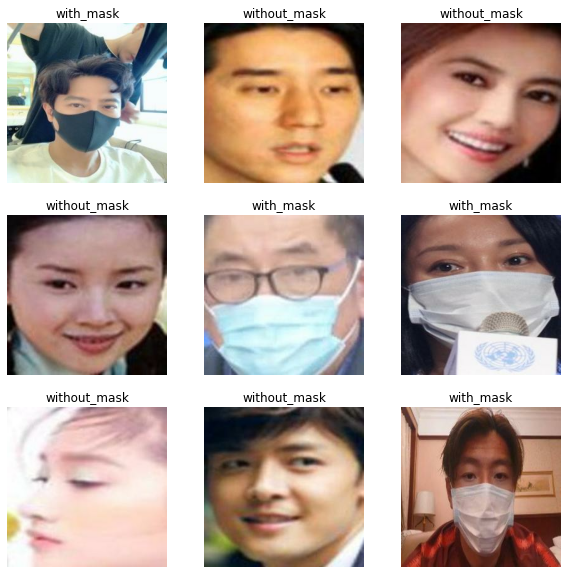

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(random.randint(1, 100)):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = len(class_names)

model = Sequential([
  #data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(), 
  #layers.Conv2D(128, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  #layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

#hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#model.compile(loss = 'categorical_crossentropy',
#                optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
#                metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                16777280  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 16,777,858
Trainable params: 16,777,858
Non-trainable params: 0
__________________________________________

In [16]:
start_time = time.time()
epochs = EPOCHS
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
model.save(SAVED_MODEL_DIR)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/5
139/139 [==============================] - 150s 990ms/step - loss: 0.8952 - accuracy: 0.8897 - val_loss: 0.1480 - val_accuracy: 0.9497
Epoch 2/5
139/139 [==============================] - 184s 1s/step - loss: 0.1041 - accuracy: 0.9668 - val_loss: 0.1238 - val_accuracy: 0.9601
Epoch 3/5
139/139 [==============================] - 168s 1s/step - loss: 0.0835 - accuracy: 0.9726 - val_loss: 0.1296 - val_accuracy: 0.9570
Epoch 4/5
139/139 [==============================] - 171s 1s/step - loss: 0.0521 - accuracy: 0.9840 - val_loss: 0.1063 - val_accuracy: 0.9647
Epoch 5/5
139/139 [==============================] - 203s 1s/step - loss: 0.0398 - accuracy: 0.9883 - val_loss: 0.1092 - val_accuracy: 0.9674
INFO:tensorflow:Assets written to: ../../dataset/../model/assets
--- 880.4962799549103 seconds ---


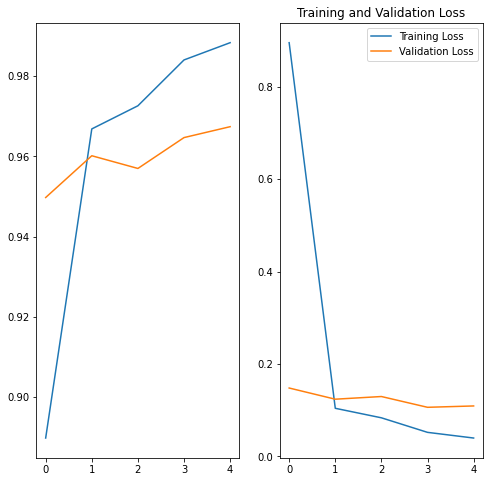

In [17]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

57344/49470 [==================================] - 0s 1us/step
This image most likely belongs to with_mask with a 100.00 percent confidence.


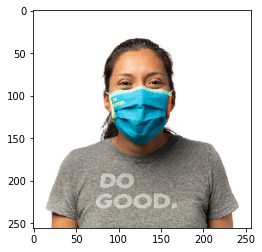

In [24]:
img_url = "https://cdn.shopify.com/s/files/1/0281/7544/products/TecaCottonMask-FacialExpressions-078_700x.jpg?v=1605320235"
#img_url =  "https://media.istockphoto.com/photos/beautiful-smiling-woman-with-clean-skin-picture-id1089292068?k=6&m=1089292068&s=612x612&w=0&h=esl0LAMEp_uastdwPu-SRjMOKi7vI33vP8L1O0ua3dU="
img_path = tf.keras.utils.get_file(f'{random.randint(0, 100000)}', origin=img_url)

img = keras.preprocessing.image.load_img(
    img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
)
_ = plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)